In [2]:
# Setup cuda environment
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-cupaxv11
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-cupaxv11
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 326b0a57a80c6d0b4bad25ca7adf8138419ef1cb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10741 sha256=1c43b610d84440f376c57bb0b3d20f87e2433fdb6f06eb98d5fd7c81c461a971
  Stored in directory: /tmp/pip-ephem-wheel-cache-r_pzvvua/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmp10yibdmi".


In [38]:
%%writefile knn_gpu.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>
#include <iostream>
#include <chrono>

#define MAX_ERR 1e-6

__global__ void knn_kernel(float *reference_points, float *query_points, int *results, int n, int m, int k, int dim) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < m) {
        float *min_distances = new float[k];
        int *min_indices = new int[k];

        for (int i = 0; i < k; ++i) {
            min_distances[i] = INFINITY;
            min_indices[i] = -1;
        }

        for (int i = 0; i < n; ++i) {
            float distance = 0;
            for (int j = 0; j < dim; ++j) {
                float diff = reference_points[i * dim + j] - query_points[idx * dim + j];
                distance += diff * diff;
            }

            for (int l = 0; l < k; ++l) {
                if (distance < min_distances[l]) {
                    for (int t = k - 1; t > l; --t) {
                        min_distances[t] = min_distances[t - 1];
                        min_indices[t] = min_indices[t - 1];
                    }
                    min_distances[l] = distance;
                    min_indices[l] = i;
                    break;
                }
            }
        }

        for (int i = 0; i < k; ++i) {
            results[idx * k + i] = min_indices[i];
        }

        delete[] min_distances;
        delete[] min_indices;
    }
}

void knn_with_cuda(float *reference_points, float *query_points, int *results, int n, int m, int k, int dim) {
    float *d_reference, *d_query;
    int *d_results;

    cudaMalloc((void **)&d_reference, sizeof(float) * dim * n);
    cudaMalloc((void **)&d_query, sizeof(float) * dim * m);
    cudaMalloc((void **)&d_results, sizeof(int) * m * k);

    cudaMemcpy(d_reference, reference_points, sizeof(float) * dim * n, cudaMemcpyHostToDevice);
    cudaMemcpy(d_query, query_points, sizeof(float) * dim * m, cudaMemcpyHostToDevice);

    int blockSize = 256;
    int numBlocks = (m + blockSize - 1) / blockSize;

    knn_kernel<<<numBlocks, blockSize>>>(d_reference, d_query, d_results, n, m, k, dim);

    cudaMemcpy(results, d_results, sizeof(int) * m * k, cudaMemcpyDeviceToHost);

    cudaFree(d_reference);
    cudaFree(d_query);
    cudaFree(d_results);
}

int main() {
    int sizes[] = {100, 1000, 10000, 50000, 100000,1000000};
    int m = 1000;  // Number of query points
    int k = 5;      // Number of nearest neighbors
    int dim = 3;    // Number of dimensions

    for (int i = 0; i < sizeof(sizes) / sizeof(sizes[0]); ++i) {
        int n = sizes[i]; // Number of reference points

        float *reference_points = (float *)malloc(sizeof(float) * dim * n);
        float *query_points = (float *)malloc(sizeof(float) * dim * m);
        int *results = (int *)malloc(sizeof(int) * m * k);

        // Initialize reference_points and query_points with random values
        for (int i = 0; i < dim * n; ++i) {
            reference_points[i] = static_cast<float>(rand()) / RAND_MAX;
        }
        for (int i = 0; i < dim * m; ++i) {
            query_points[i] = static_cast<float>(rand()) / RAND_MAX;
        }

        auto start = std::chrono::high_resolution_clock::now();
        knn_with_cuda(reference_points, query_points, results, n, m, k, dim);
        auto end = std::chrono::high_resolution_clock::now();

        std::chrono::duration<float, std::milli> duration = end - start;
        std::cout << "Time taken with CUDA for n=" << n << ": " << duration.count() << " milliseconds" << std::endl;

        free(reference_points);
        free(query_points);
        free(results);
    }

    return 0;
}

Overwriting knn_gpu.cu


In [39]:
!nvcc knn_gpu.cu -o knn_gpu
!./knn_gpu

Time taken with CUDA for n=100: 116.925 milliseconds
Time taken with CUDA for n=1000: 4.17833 milliseconds
Time taken with CUDA for n=10000: 25.4958 milliseconds
Time taken with CUDA for n=50000: 108.707 milliseconds
Time taken with CUDA for n=100000: 147.129 milliseconds
Time taken with CUDA for n=1000000: 911.613 milliseconds


In [40]:
!nvcc knn_gpu.cu -o knn_gpu
!./knn_gpu > output.txt

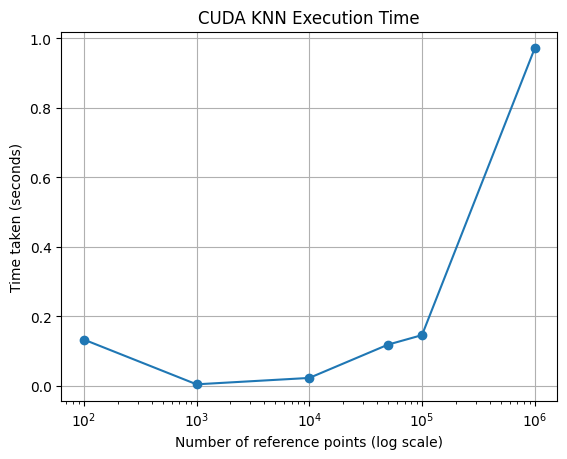

In [41]:
import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 50000, 100000, 1000000]
times = []

with open('output.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith('Time taken with CUDA'):
            time_str = line.split(': ')[1].split(' ')[0]
            time_sec = float(time_str) / 1000  # Convert milliseconds to seconds
            times.append(time_sec)

plt.plot(sizes, times, marker='o')
plt.xscale('log')  # Use logarithmic scale for x-axis
plt.xlabel('Number of reference points (log scale)')
plt.ylabel('Time taken (seconds)')
plt.title('CUDA KNN Execution Time')
plt.grid(True)
plt.show()

In [46]:
%%writefile knn2_gpu.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>
#include <iostream>
#include <chrono>

#define MAX_ERR 1e-6

__global__ void knn_kernel(float *reference_points, float *query_points, int *results, int n, int m, int k, int dim) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < m) {
        float *min_distances = new float[k];
        int *min_indices = new int[k];

        for (int i = 0; i < k; ++i) {
            min_distances[i] = INFINITY;
            min_indices[i] = -1;
        }

        for (int i = 0; i < n; ++i) {
            float distance = 0;
            for (int j = 0; j < dim; ++j) {
                float diff = reference_points[i * dim + j] - query_points[idx * dim + j];
                distance += diff * diff;
            }

            for (int l = 0; l < k; ++l) {
                if (distance < min_distances[l]) {
                    for (int t = k - 1; t > l; --t) {
                        min_distances[t] = min_distances[t - 1];
                        min_indices[t] = min_indices[t - 1];
                    }
                    min_distances[l] = distance;
                    min_indices[l] = i;
                    break;
                }
            }
        }

        for (int i = 0; i < k; ++i) {
            results[idx * k + i] = min_indices[i];
        }

        delete[] min_distances;
        delete[] min_indices;
    }
}

void knn_with_cuda(float *reference_points, float *query_points, int *results, int n, int m, int k, int dim) {
    float *d_reference, *d_query;
    int *d_results;

    cudaMalloc((void **)&d_reference, sizeof(float) * dim * n);
    cudaMalloc((void **)&d_query, sizeof(float) * dim * m);
    cudaMalloc((void **)&d_results, sizeof(int) * m * k);

    cudaMemcpy(d_reference, reference_points, sizeof(float) * dim * n, cudaMemcpyHostToDevice);
    cudaMemcpy(d_query, query_points, sizeof(float) * dim * m, cudaMemcpyHostToDevice);

    int blockSize = 256;
    int numBlocks = (m + blockSize - 1) / blockSize;

    knn_kernel<<<numBlocks, blockSize>>>(d_reference, d_query, d_results, n, m, k, dim);

    cudaMemcpy(results, d_results, sizeof(int) * m * k, cudaMemcpyDeviceToHost);

    cudaFree(d_reference);
    cudaFree(d_query);
    cudaFree(d_results);
}

int main() {
    int sizes[] = {100, 1000, 10000, 50000, 100000, 1000000};
    int k_values[] = {5, 7, 17, 111, 231};
    int m = 1000;  // Number of query points
    int dim = 3;    // Number of dimensions

    FILE *output_file = fopen("output2.txt", "w");
    if (output_file == NULL) {
        fprintf(stderr, "Error opening output file\n");
        return 1;
    }

    for (int k_idx = 0; k_idx < sizeof(k_values) / sizeof(k_values[0]); ++k_idx) {
        int k = k_values[k_idx];
        fprintf(output_file, "k=%d\n", k);

        for (int i = 0; i < sizeof(sizes) / sizeof(sizes[0]); ++i) {
            int n = sizes[i]; // Number of reference points

            float *reference_points = (float *)malloc(sizeof(float) * dim * n);
            float *query_points = (float *)malloc(sizeof(float) * dim * m);
            int *results = (int *)malloc(sizeof(int) * m * k);

            // Initialize reference_points and query_points with random values
            for (int i = 0; i < dim * n; ++i) {
                reference_points[i] = static_cast<float>(rand()) / RAND_MAX;
            }
            for (int i = 0; i < dim * m; ++i) {
                query_points[i] = static_cast<float>(rand()) / RAND_MAX;
            }

            auto start = std::chrono::high_resolution_clock::now();
            knn_with_cuda(reference_points, query_points, results, n, m, k, dim);
            auto end = std::chrono::high_resolution_clock::now();

            std::chrono::duration<float, std::milli> duration = end - start;
            fprintf(output_file, "%d %f\n", n, duration.count());

            free(reference_points);
            free(query_points);
            free(results);
        }
        fprintf(output_file, "\n");
    }

    fclose(output_file);

    return 0;
}


Overwriting knn2_gpu.cu


In [47]:
!nvcc knn2_gpu.cu -o knn2_gpu
!./knn2_gpu

In [48]:
!nvcc knn2_gpu.cu -o knn2_gpu
!./knn2_gpu >output2.txt

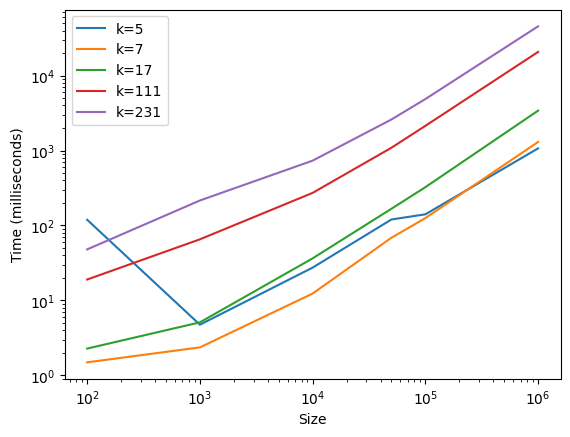

In [50]:
import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 50000, 100000, 1000000]
k_values = [5, 7, 17, 111, 231]

with open('output.txt', 'r') as f:
    lines = f.readlines()

data = {}
current_k = None
for line in lines:
    if line.strip():  # Skip empty lines
        if line.startswith('k='):
            current_k = int(line.split('=')[1])
            data[current_k] = {'sizes': [], 'times': []}
        else:
            size, time = map(float, line.split())
            data[current_k]['sizes'].append(size)
            data[current_k]['times'].append(time)

for k, values in data.items():
    plt.plot(values['sizes'], values['times'], label=f'k={k}')

plt.xlabel('Size')
plt.ylabel('Time (milliseconds)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
